In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numba
from random import choices, expovariate
#from pqdict import pqdict

In [2]:
a=np.array([1,2,3,4,5])
np.cumsum(a)
@numba.njit()
def weighted_prob(arr,p,s=1):
    #assuming sum(p)==1
    return arr[np.searchsorted(np.cumsum(p),np.random.random()*s,side='right')]
testArr=np.random.randint(0,3,size=(10000,200))
testP=np.random.random(size=10000)
testP=testP/testP.sum()
print(np.cumsum(testP))
weighted_prob(testArr,testP)
#%timeit weighted_prob(testArr,testP)
#%timeit testArr[np.random.choice(len(testArr),p=testP)]

[1.79782353e-04 2.85107662e-04 3.90834762e-04 ... 9.99878286e-01
 9.99903103e-01 1.00000000e+00]


array([0, 1, 0, 2, 0, 2, 1, 0, 1, 2, 2, 1, 1, 1, 2, 0, 0, 0, 1, 0, 1, 2,
       2, 2, 0, 2, 1, 0, 0, 2, 0, 2, 1, 1, 2, 2, 2, 2, 0, 1, 0, 0, 1, 1,
       0, 0, 2, 0, 2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 0, 2, 1, 0,
       0, 1, 1, 2, 2, 2, 1, 1, 0, 2, 0, 1, 0, 0, 0, 2, 1, 1, 0, 1, 2, 2,
       2, 1, 0, 2, 1, 1, 1, 0, 0, 1, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 1,
       1, 2, 1, 2, 1, 0, 2, 1, 0, 1, 0, 0, 0, 1, 0, 1, 2, 2, 0, 2, 2, 1,
       2, 0, 2, 1, 2, 0, 0, 1, 2, 0, 0, 2, 2, 0, 2, 0, 1, 2, 0, 1, 0, 2,
       2, 0, 1, 0, 1, 0, 2, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 2, 0, 2, 1, 1,
       0, 2, 1, 0, 1, 2, 2, 1, 2, 1, 0, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2,
       1, 0])

Simulating the effects of intercellular signalling in transcription variation and regulation

Unicellular vs multicellular dynamics of reporter protein production

In [3]:
''''
species: [S0...Sn]
rxn_changes=[[c0...cn]...] MxN
rxn_laws [[e0...en]...] MxN 0 if not participating
rxn_constants [k0...km]
propensities=rxn_constants*(species**rxn_laws).prod(1) => M
choose from choice=0...M-1
species+=rxn_changes[choice]

reaction lang:
{species_name:startVal}
'''
#@numba.njit()
def gillespieStepBetter(species,changes,laws,constants):
    propensities=constants*np.prod(species**laws,axis=1)
    summed=propensities.sum()
    action = weighted_prob(changes,p=propensities/summed)
    #print()
    return action,expovariate(summed)
@numba.njit()
def numbaGillespieStep(species,changes,laws,constants):
    propensities=np.ones(changes.shape[0],np.float64)#*constants
    for i in range(changes.shape[0]):
        propensities[i]=np.prod(species**laws[i])
    propensities*=constants
    summed=propensities.sum()
    #print(summed)
    action = weighted_prob(changes,p=propensities/summed)
    #print()
    return action,expovariate(summed)
#@numba.njit
def gillespieRunBetter(species,changes,laws,constants,tstart,tend):
    t=tstart
    concentrations=[species.copy()]
    ts=[tstart]
    while t<tend:
        dConc,dt=gillespieStepBetter(species,changes,laws,constants)
        t+=dt
        species+=dConc
        concentrations.append(species.copy())
        ts.append(t)
        #print(t)
    return concentrations,ts
def gillespieFixedTimeStep(species,changes,laws,constants,dt=0.05):
    propensities=constants*np.prod(species**laws,axis=1)
    #print(propensities,species**laws,species)
    summed=propensities.sum()
    if summed==0:
        #print(propensities,species**laws,species)
        return np.zeros_like(changes[0]),dt#gillespieFixedTimeStep(species,changes,laws,constants,dt=0.05)
    action_idx = np.random.choice(len(changes),p=propensities/summed)
    return changes[action_idx],dt
def gillespieRunFixedTime(species,changes,laws,constants,tstart,tend,dt):
    t=tstart
    concentrations=[species.copy()]
    ts=[tstart]
    while t<tend:
        dConc,dt=gillespieFixedTimeStep(species,changes,laws,constants)
        #print(dConc)
        t+=dt
        species+=dConc
        concentrations.append(species.copy())
        ts.append(t)
    return concentrations,ts
NA=6.022*10**23
def k2c(k,v,deg=1):
    if deg==2:
        return k/(v*NA)
    if deg==1:
        return k
    if deg==0:
        return v*k
'''
For A+B=>AB
kf=1
kr=1
A0=1000
B0=1000
'''
sp=np.array([10000.,10000.,0])
ds=np.array([[-1,-1,1.],[1.,1,-1]])
laws=np.array([[1,1,0.],[0.,0,1]])
#rates=np.array([k2c(10,1e-6,2),k2c(1,1e-6,1)])
#rates=np.array([1,1])
#concs,ts=gillespieRunBetter(sp,ds,laws,rates,0,1e-2)
def plotGillespie(species,changes,laws,constants,tstart,tend,idxs=slice(None,None,None)):
    conc,ts=gillespieRunBetter(species, changes,laws,constants,tstart,tend)
    #print(ts)
    #print(conc)

    conc=np.array(conc)
    #print(conc)
    plt.plot(ts,conc[:,idxs])
    plt.show()
'''
TF+DNA=>TF.DNA
TF.DNA=>TF+DNA
TF.DNA=>mRNA_TF+TF.DNA
mRNA_TF=>null
mRNA_TF=>TF+P
TF=>TF_out
TF_out=>TF
TF=>null
P=>null
~~
A_out=>A
A=>A_out
A+DNA=>A.DNA
A.DNA=>A+DNA
A.DNA=>TF
[tf_out,tf,dna,tf.dna,mrna_tf,null,P]
'''
TFchanges=np.array([
    [0,-1,-1,1,0,0,0],
    [0,1,1,-1,0,0,0],
    [0,0,0,0,1,0,0],
    [0,0,0,0,-1,1,0],
    [0,1,0,0,0,0,1],
    [1,-1,0,0,0,0,0],
    [-1,1,0,0,0,0,0],
    [0,-1,0,0,0,1,0],
    [0,0,0,0,0,1,-1]
])
tfRates=np.array([.01,1,.1,.5,1,1,.1,.01,.1])
tfLaws=(TFchanges==-1).astype(float)
tfLaws[2,3]=1
tfLaws[4,4]=1
t0=np.array([0,10,1000,0,0,0,0])
#print(tfLaws)
#k * Na molecules/mol * V
#print(tfConcs[:,[2,3]].sum(1))
#plotGillespie(t0,TFchanges,tfLaws,tfRates,0,200)

In [ ]:
gillespieStepBetter(t0,TFchanges,tfLaws,tfRates)

In [ ]:
!pip install line_profiler

In [ ]:
t0=np.array([10,0,100,0,0,0,0])
tfConcs,tfTs=gillespieRunFixedTime(t0,TFchanges,tfLaws,tfRates,0,1000,dt=0.01)
tfConcs=np.stack(tfConcs)
print('single cell')
plt.plot(tfTs,tfConcs[:,-1])
plt.show()
print('mean stable concentration of reporter: ', tfConcs[-1000:,-1].mean())

In [ ]:
from line_profiler import LineProfiler
profiler=LineProfiler()
def profile(func):
    def inner(*args, **kwargs):
        profiler.add_function(func)
        profiler.enable_by_count()
        return func(*args, **kwargs)
    return inner

@profile
def stepProfile(species, changes, laws, constants):
    #print((species**laws)[0])
    propensities=constants*np.prod(species**laws,axis=1)
    propensities+=1
    #print(np.prod(propensities[0]),(propensities[0]==0).any())
    summed=propensities.sum()
    action_idx = np.random.choice(len(changes),p=propensities/summed)
    #print()
    dt=expovariate(summed)
    #
    return changes[action_idx],dt
#stepProfile(t0,TFchanges,tfLaws,tfRates)
profileSpeciesN=1000
profileRxnN=20
stepProfile(np.random.randint(low=1,high=1000,size=profileSpeciesN),np.random.randint(low=-2,high=2,size=(profileRxnN,profileSpeciesN)),np.random.randint(0,3,size=(profileRxnN,profileSpeciesN)),np.random.uniform(1,20,size=profileRxnN))
profiler.print_stats()

In [ ]:
t0=np.array([10,0,100*20,0,0,0,0])
tfConcs,tfTs=gillespieRunFixedTime(t0,TFchanges,tfLaws,tfRates,0,1000,dt=0.01)
tfConcs=np.stack(tfConcs)
print("20x cell size")
plt.plot(tfTs,tfConcs[:,-1])
plt.show()
print('mean stable concentration of reporter: ', tfConcs[-1000:,-1].mean())

In [ ]:
print('mean stable concentration of reporter: ', tfConcs[-1000:,-1].mean())

In [4]:
class Cell:
    def __init__(self, s0, changes,laws, constants,shared_idxs,tstart):
        self.species=s0.copy()#includes shared
        self.changes=changes
        self.laws=laws
        self.constants=constants
        self.shared_idxs=shared_idxs
        self.recordList=[]
        self.t=tstart
    def gillespieStep(self):
        ds,dt=gillespieStepBetter(self.species,self.changes,self.laws,self.constants)
        self.species+=ds
        self.t+=dt
        return ds,dt
    def gillespieFTStep(self,dt):
        #print(self.species)
        ds,dt=gillespieFixedTimeStep(self.species,self.changes,self.laws,self.constants,dt)
        self.species+=ds
        self.t+=dt
        return ds,dt
    def record(self):
        self.recordList.append((self.t,self.species.copy()))
def multiCell(cells, s0,changes,laws,constants,share_idxs,dt,endTime,conc_idxs=slice(None,None,None)):
    concentrations=s0[conc_idxs].copy()
    shared_conc=s0[share_idxs].copy()
    #print(shared_conc)
    t=0
    while t<endTime:
        #accumulatedChange=np.zeros_like(shared_conc)
        for cell in cells:
            ds,dtCell=cell.gillespieFTStep(dt)
            shared_conc+=ds[share_idxs]
            for cell2 in cells:
                cell2.species[share_idxs]=np.clip(shared_conc,0,None)
                #cell2.record()
            cell.record()
        t+=dt
    return cells

#print(tfLaws)
t0=np.array([10,0,100,0,0,0,0])
cells=[Cell(t0,TFchanges,tfLaws,tfRates,[0],0) for i in range(20)]
#cells=multiCell(cells,t0,TFchanges,tfLaws,tfRates,[0],0.01,1000)
def stackCells(nCells, s0,changes,laws,constants,share_idxs):
    #would be best if all shared was in the front of each
    ns=len(s0)
    nm=len(laws)
    nShare=len(share_idxs)
    allSpecies=np.zeros(nCells*(ns-len(share_idxs))+len(share_idxs))
    allSpecies[:share_idxs]=s0[share_idxs]*nCells
    nonShareSize=ns-nShare
    for i in range(nCells):
        allSpecies[share_idxs+i*nonShareSize:share_idxs+(i+1)*nonShareSize]=s0[share_idxs].copy()
        #share_idxs+i*nonShareSize:share_idxs+(i+1)*nonShareSize


In [ ]:
cell0=cells[0]
cell0Times=[i[0] for i in cell0.recordList]
cell0Record=np.stack([i[1] for i in cell0.recordList])
def splitCell(cell):
    times=[i[0] for i in cell.recordList]
    concs=np.stack([i[1] for i in cell.recordList])
    return times,concs
def plotCell(cell, species_idx):
    times=[i[0] for i in cell.recordList]
    concs=np.stack([i[1] for i in cell.recordList])
    plt.plot(times,concs[:,species_idx])
    plt.show()
def mean(x):
    return sum(x)/len(x)
sum_p=sum([splitCell(cell)[1][-1000:,-1].mean() for cell in cells])
mean_p=mean([splitCell(cell)[1][-1000:,-1].mean() for cell in cells])
print("sum of reporter concentrations across all cells:",sum_p)
print("mean reporter concentration per cell: ",mean_p)

In [ ]:
plotCell(cells[11],-1)

In [ ]:
cell0Record[:,-1][-100:].mean()

In [ ]:
tfConcs[:,-1][-100:].mean()

In [ ]:
cell0Record[:,-1]

In [ ]:
sum(cell.species[-1] for cell in cells),sum(cell.species[1] for cell in cells)

In [ ]:
test_concs,test_ts=gillespieRunFixedTime(np.array([100,0]),np.array([[-1,1],[1,-1]]),np.array([[1,0],[0,1]]),np.array([1,1]),0,50,0.01)
plt.plot(test_ts,test_concs)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
def euler(dy,y0,x0,h,n):
    yn=y0
    ys=[y0]
    xn=x0
    for i in range(n):
        yn=yn+h*dy(xn,yn)
        xn+=h
        ys.append(yn)
    return ys
plt.plot(range(1001),euler(lambda x,y: -2*y,1,0,.001,1000))
plt.show()

In [4]:
t0.shape

(7,)

In [10]:
@numba.njit()
def tauStep(species, laws,changes, rates,dt):
    propensities=np.ones(laws.shape[0],np.float64)

    for i in range(len(propensities)):
        propensities[i]=np.prod(species**laws[i])
    #print(propensities)
    propensities*=rates
    ds=np.zeros(species.shape[0],np.float64)
    #print(propensities.shape,ds.shape)
    for i in range(len(ds)):
        for j in range(len(propensities)):
            p=np.random.poisson(propensities[j]*dt)
            #print(p)
            #print(propensities[j]*dt,propensities[j],dt)
            ds[i]+=changes[j,i]*p
    return ds
tauStep(t0.astype(float),tfLaws.astype(float),TFchanges.astype(float),tfRates,0.01)


array([ 0.,  0., -1.,  0.,  0.,  0.,  0.])

In [5]:
import xml.etree.ElementTree as ET
from collections import OrderedDict as odict
import numpy as np
import re
def fixVCML(fname):
    xmlStr=''
    with open(fname,'r') as f:
        xmlStr=''.join(list(f))
    xmlStr=re.sub(' xmlns="[^"]+"', '', xmlStr, count=1)
    tree=ET.fromstring(xmlStr)

    return tree
def parseModel(model_xml):
    compounds=odict()
    assoc_v=odict()
    rxns=[]
    stoich=[]
    for child in model_xml:
        if child.tag=='LocalizedCompound':
            compounds[child.attrib['Name']]=0
            assoc_v[child.attrib['Name']]=child.attrib['Structure']
    return compounds, assoc_v
def parseCompartmentJumps(compartment_xml,compounds):
    rxn_jump=odict()#keyed to reaction names:jump vector
    rxn_stoich=odict()
    compound_list=list(compounds.keys())
    for c in compartment_xml:
        if c.tag=='JumpProcess':
            rxn_jump[c.attrib['Name']]=np.zeros(len(compounds))
            rxn_stoich[c.attrib['Name']]=np.zeros(len(compounds))
            for i in c:
                potentialHidden=[]
                if i.tag=='Effect':
                    idx=list(compounds.keys()).index(i.attrib['VarName'].replace('_Count',''))
                    coeff=int(float(i.text))
                    if coeff==0:
                        potentialHidden.append(idx)
                    elif coeff<0:
                        rxn_stoich[c.attrib['Name']][idx]=-coeff
                    rxn_jump[c.attrib['Name']][idx]=coeff
                if not (rxn_jump[c.attrib['Name']]<0).any():
                    for idx in potentialHidden:
                        rxn_stoich[c.attrib['Name']][idx]=1
    return rxn_jump,rxn_stoich



def adjust_constants(rates, stoichs, rxn_assoc_v,override_v=5000):
    #assumes rates are in uM if there is more than one
    kmole=0.0016605387#represents 1/(s*molecules) i think
    #molecules = 10^-6 * C uM * 10^-15 * V um^3 *6.022*10^23 = C * 6.022*10^2 * V
    #k [=] 1/(s*uM^(order-1))=>1/(s*(molecules)^(order-1))
    #k in uM * uM 1/(s* 6.022*10^2 * V)
    orders=stoichs.sum(-1)
    return rates * 1/((6.022*100*rxn_assoc_v)**(orders-1))
def parseVCML(fname):
    root=fixVCML(fname)
    constants = odict()#keyed to names
    compounds=odict() #keyed to compound names:concentration
    rxn_stoichs=odict()#keyed to reaction names:stoich vector
    rate_constants=odict()#keyed to reaction names
    compartments=odict()#keyed to compartment names
    rxn_jumps=odict()
    compound_assoc_v=odict()#volumes of the compartments each compound is in, 1d
    rxn_assoc_v=odict()#volumes that each reaction takes place, 1d
    rxn_ks=0
    print(list(root[0]))
    for child in root[0]:
        name=child.tag
        if child.tag=='Model':
            compounds,compound_assoc_v=parseModel(child)#compound assoc_v is just names for rn
        elif child.tag=='SimulationSpec':
            print(child.attrib)
            if child.attrib['Stochastic']=='true':
                for child2 in child:
                    if child2.tag=='MathDescription':
                        for c in child2:
                            if c.tag=='Constant':
                                try:
                                    constants[c.attrib['Name']]=float(c.text)
                                except ValueError as ve:
                                    print(c.text,c.attrib['Name'],ve)
                                    pass
                            elif c.tag=='CompartmentSubDomain':
                                rxn_jumps,rxn_stoichs=parseCompartmentJumps(c,compounds)
                                #print(rxn_jumps)
                                rxn_ks=[constants[f"Kr_{i[:-8]}"] if 'reverse' in i else constants[f'Kf_{i}'] for i in rxn_jumps]
            if len(constants)>0:
                for v in compound_assoc_v:
                    name=compound_assoc_v[v]
                    #print(constants)
                    compound_assoc_v[v]=constants['Size_'+name]
                break


    for name in compounds: #fills conc arr with number of molecules
        #compounds[name]=np.round(constants[name+'_Count_init_uM']*compound_assoc_v[name]*6.022*100)
        compounds[name]=constants[name+'_Count_initCount']
    
    #rxn_ks['Kr__3OC6HSLdiffusion']*=compound_assoc_v['_3OC6HSL_inside']/compound_assoc_v['_3OC6HSL_out']#idk why its like this but yeah
    compound_names=list(compounds.keys())
    rxn_names=list(rxn_stoichs)
    constant_names=list(constants)
    rxn_ks[3]*=constants['Size_Environment']/constants['Size_Cell']
    conc_arr=np.array(list(compounds.values()))
    jump_arr=np.array([rxn_jumps[i] for i in rxn_jumps])
    stoich_arr=np.array(list(rxn_stoichs.values()))
    rate_arr=np.array(rxn_ks)
    v_arr=np.array(list(compound_assoc_v.values()))
    for r in rxn_stoichs:
        idx=np.where(rxn_stoichs[r]>0)[0][0]
        #print(np.where(rxn_stoichs[r]>0))
        rxn_assoc_v[r]=compound_assoc_v[compound_names[idx]]
    rxn_v_arr=np.array(list(rxn_assoc_v.values()))
    adjusted=adjust_constants(rxn_ks,stoich_arr,rxn_v_arr)
    for i in range(len(rxn_ks)):
        print(adjusted[i],list(rxn_stoichs)[i],i)
    return compounds,jump_arr,stoich_arr,rate_arr,v_arr,rxn_v_arr

compounds,changes,stoichs,rates,v_assoc,rv_assoc=parseVCML('SF_testing1.vcml')
rates=adjust_constants(rates,stoichs,rv_assoc)
print(rates)
compounds['Deg_GFPmRNA']=100
print(compounds.keys())

[<Element 'Annotation' at 0x138113310>, <Element 'Model' at 0x138113360>, <Element 'SimulationSpec' at 0x13819c950>, <Element 'SimulationSpec' at 0x1381e0680>, <Element 'Version' at 0x1382424a0>, <Element 'pathwayModel' at 0x1382425e0>, <Element 'relationshipModel' at 0x1382427c0>, <Element 'vcmetadata' at 0x138242860>]
{'Name': 'Application0', 'Stochastic': 'false', 'UseConcentration': 'true', 'RuleBased': 'false', 'MassConservationModelReduction': 'false', 'InsufficientIterations': 'false', 'InsufficientMaxMolecules': 'false'}
{'Name': 'Stochastic', 'Stochastic': 'true', 'UseConcentration': 'false', 'RandomizeInitCondition': 'false', 'RuleBased': 'false', 'MassConservationModelReduction': 'false', 'InsufficientIterations': 'false', 'InsufficientMaxMolecules': 'false'}
(1.0 * pow(KMOLE,-1.0)) UnitFactor_molecules_uM_neg_1_um_neg_3 could not convert string to float: '(1.0 * pow(KMOLE,-1.0))'
(1.0 * pow(KMOLE,1.0)) UnitFactor_uM_um3_molecules_neg_1 could not convert string to float: '(1

In [64]:
rates

array([6.70000000e-02, 0.00000000e+00, 1.00000000e+00, 1.00000000e+03,
       5.51311857e-06, 1.66000000e-02, 1.00000000e+01, 0.00000000e+00,
       1.00000000e-01, 1.00000000e-01, 6.70000000e-02, 0.00000000e+00,
       5.00000000e+00, 0.00000000e+00, 1.15300000e-03, 0.00000000e+00,
       1.53000000e-03, 0.00000000e+00, 1.15300000e-03, 0.00000000e+00,
       5.51311857e-05, 1.66000000e-01, 3.32115576e-02, 1.00000000e-02,
       1.00000000e+01, 0.00000000e+00, 6.70000000e-02, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 4.20000000e-05, 0.00000000e+00,
       4.20000000e-03, 0.00000000e+00, 4.20000000e-03, 0.00000000e+00,
       4.00000000e-04, 0.00000000e+00])

In [ ]:
len(compounds),len(rates),changes.shape

In [ ]:
concs,ts=gillespieRunBetter(np.array(list(compounds.values())),changes,stoichs,adjust_constants(rates,stoichs,v_assoc),0,100)

In [ ]:
len(concs),len(ts)

In [ ]:
nconcs=np.stack(concs)

In [ ]:
compound_names=list(compounds.keys())
compound_names

In [ ]:
plt.plot(ts[::10000],nconcs[::10000,compound_names.index('LuxRinCell')])

In [ ]:
@profile
def stepProfile2(species, changes, laws, constants,iters=1000):
    record_c=[]
    record_t=[]
    for i in range(iters):
        #print((species**laws)[0])
        propensities=constants*np.prod(species**laws,axis=1)
        #print(np.prod(propensities[0]),(propensities[0]==0).any())
        summed=propensities.sum()
        action_idx = np.random.choice(len(changes),p=propensities/summed)
        #print()
        dt=expovariate(summed)
        #
        record_c.append(changes[action_idx])
        record_t.append(dt)
    return record_c,record_t
stepProfile2(np.array(list(compounds.values())),changes,stoichs,adjust_constants(rates,stoichs,v_assoc))
profiler.print_stats()

In [6]:
from numba import int32, float32, float64 , int64   # import the types
from numba.experimental import jitclass
cell_spec=[
    ('species',float64[:]),
    ('changes',float64[:,:]),
    ('stoichs',float64[:,:]),
    ('rates',float64[:]),
    ('assoc_v',float64[:])
]
@jitclass(cell_spec)
class ICell:
    def __init__(self, species, changes,stoichs,rates,assoc_v):
        self.species=species
        self.changes=changes
        self.stoichs=stoichs
        self.rates=rates
        self.assoc_v=assoc_v
#the way these are implemented I need to figure out a better way to change reaction rates when the volumes of the cells change but thats a problem for later
#@numba.njit()
def stacked_multicellular(cells,shared_idx,timestep,t0,tend):
    record=np.empty(size=(len(cells),(tend-t0)//timestep,cells[0].species.shape[0]))
    nonShared=np.arange(len(cells))[np.isin(np.arange(len(cells)),shared_idx,invert=True)]
    t=t0
    tcount=0
    steps=(tend-t0)//timestep
    totalSpecies=sum(len(cell.species) for cell in cells)
    totalRxns=sum(len(cell.changes) for cell in cells)
    allSpecies=np.empty(totalSpecies)
    allLaws=np.empty(size=(totalRxns,totalSpecies))
    allRates=np.empty(size=totalRxns)
    allChanges=np.empty(size=(totalRxns,totalSpecies))
    allSharedIdx=np.empty(len(shared_idx))
    sidx=0
    ridx=0
    cellCount=0
    for cell in cells:
        cellSpecies=cell.species
        cellRxns=cell.changes
        allSpecies[sidx:sidx+len(cellSpecies)]=cellSpecies
        allLaws[ridx:ridx+cellRxns.shape[0],sidx:sidx+len(cellSpecies)]=cell.stoichs
        allChanges[ridx:ridx+cellRxns.shape[0],sidx:sidx+len(cellSpecies)]=cell.changes
        allRates[ridx:ridx+cellRxns.shape[0]]=cell.rates
        allSharedIdx[cellCount*len(shared_idx):(cellCount+1)*len(shared_idx)]=shared_idx+sidx
        sidx+=len(cellSpecies)
        ridx+=cellRxns.shape[0]
    for i in range(len(allLaws)):
        sharedChanges=allChanges[allSharedIdx]
        #laws can stay the same as long as all the shared are updated 
        if allChanges[allSharedIdx].any():
            
            allLaws[allSharedIdx]=allLaws[allSharedIdx]
    for i in range(steps):
        #make every cell a compartment
        while tcount<timestep:
            ds,dt=gillespieStep(allSpecies,allChanges,allLaws,allRates)
            allSpecies+=ds      
######
def stacked_multicellular2(cells,shared_idx,timestep,t0,tend):
    #assumed shared_idx is the same across all cells 
    #assuming all cells are the same 
    #shared species will go at the front of the new species array and be taken out of their normal spots for each cell 
    #laws and stoichs will have their shared_idx removed and transferred to the start 
    ts=np.arange(t0,tend,timestep)
    record=np.empty(size=(len(cells),len(ts),cells[0].species.shape[0]))
    nonShared=np.arange(len(cells))[np.isin(np.arange(len(cells)),shared_idx,invert=True)]
    steps=(tend-t0)//timestep
    nshared=len(shared_idx)
    totalSpecies=nshared+sum(len(cell.species)-nshared for cell in cells)
    totalRxns=sum(len(cell.changes) for cell in cells)
    allSpecies=np.empty(totalSpecies)
    allLaws=np.empty(size=(totalRxns,totalSpecies))
    allRates=np.empty(size=totalRxns)
    allChanges=np.empty(size=(totalRxns,totalSpecies))
    allSharedIdx=np.empty(len(shared_idx))
    sidx=nshared
    ridx=0
    allSpecies[:sidx]=cells[0].species[shared_idx]
    for cell in cells:
        cellSpecies=cell.species
        cellRxns=cell.changes
        nextSidx=sidx+len(cellSpecies)-nshared
        allSpecies[sidx:sidx+len(cellSpecies)-nshared]=cellSpecies
        
        allLaws[ridx:ridx+cellRxns.shape[0],sidx:nextSidx]=cell.stoichs[:,nonshared]
        allLaws[ridx:ridx+cellRxns.shape[0],:nshared]=cell.stoichs[:,shared_idx]
        allChanges[ridx:ridx+cellRxns.shape[0],sidx:nextSidx]=cell.changes[:,nonshared]
        allChanges[ridx:ridx+cellRxns.shape[0],:nshared]=cell.changes[:,shared_idx]
        allRates[ridx:ridx+cellRxns.shape[0]]=cell.rates
        #allSharedIdx[cellCount*len(shared_idx):(cellCount+1)*len(shared_idx)]=shared_idx+sidx
        sidx+=len(cellSpecies)
        ridx+=cellRxns.shape[0]
    tcount=0
    for i in range(len(ts)):
        while tcount<timestep:
            ds,dt=numbaGillespieStep(allSpecies,allLaws,allChanges,allRates)
            tcount+=dt
            allSpecies+=ds
        tcount=0
        for j in len(cells):
            nspecies=len(cells[i].species)
            record[i,j*nspecies:(j+1)*nspecies,nshared:]=allSpecies[nshared+j*len(unshared)]
    record[:,:,:nshared]=allSpecies[:nshared]
    return ts,record


from math import ceil,floor
from copy import copy
#this also doesn't scale well when the number of cells is changing but oh well
@numba.njit(parallel=False)
def parallel_multicellular(cells,shared_idx,timeStep,t0,tend):
    #based off of that one paper with parallel simulations and MPI
    shared=cells[0].species[shared_idx].copy()
    ts=np.arange(t0,tend,timeStep)
    record=np.empty((len(cells),len(ts),cells[0].species.shape[0]),np.float64) #(cells,time steps, number species)
    for i in numba.prange(len(cells)):
        cell=cells[i]
        for j in range(ts.shape[0]):
            if j%100<50:
                #print(f'cell {i} still going at t={j}/{ts.shape[0]}')
                pass
            else:
                #print(j,j%100)
                pass
            #print(i,j,ts.shape[0])
            cell.species[shared_idx]=shared[:]
            tcount=0
            accumulated_share_change=np.zeros(len(shared_idx),np.float64)
            while tcount<timeStep:
                ds,dt=numbaGillespieStep(cell.species,cell.changes,cell.stoichs,cell.rates)
                #print(ds)
                dt=timeStep
                tcount+=dt
                cell.species+=ds
                accumulated_share_change+=ds[shared_idx]
            shared+=accumulated_share_change
            record[i,j,:]=cell.species
    return ts,record

@numba.njit(parallel=False)
def parallel_multicellular2(cells,shared_idx,timeStep,t0,tend):
    #based off of that one paper with parallel simulations and MPI
    shared=cells[0].species[shared_idx].copy()
    ts=np.arange(t0,tend,timeStep)
    record=np.empty((len(cells),len(ts),cells[0].species.shape[0]),np.float64) #(cells,time steps, number species)
    for j in range(ts.shape[0]):
        for i in numba.prange(len(cells)):
            cell=cells[i]
            cell.species[shared_idx]=shared[:]
            tcount=0
            accumulated_share_change=np.zeros(len(shared_idx),np.float64)
            while tcount<timeStep:
                ds,dt=numbaGillespieStep(cell.species,cell.changes,cell.stoichs,cell.rates)
                #print(ds)
                dt=timeStep
                tcount+=dt
                cell.species+=ds
                accumulated_share_change+=ds[shared_idx]
            shared+=accumulated_share_change
            record[i,j,:]=cell.species
    return ts,record
    
#ts,cell_concs=sequential_multicellular(cells,np.array([0]),0.001,0,10)

In [20]:
print("yeet",end='\r')
print('fh')

fhet


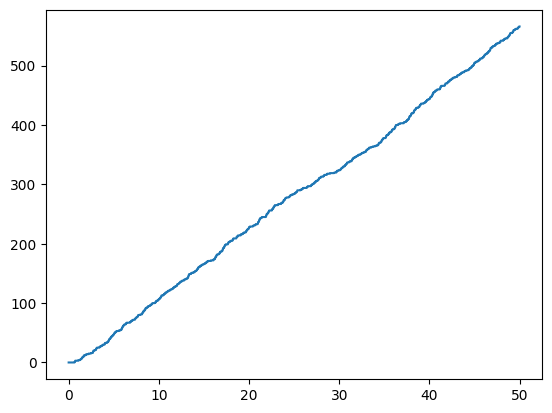

In [64]:
#[tf_out,tf,dna,tf.dna,mrna_tf,null,P]
plt.plot(ts,cell_concs[0,:,-1])

In [61]:
t1=t0.copy()
ts1,cell_concs1=parallel_multicellular2([ICell(t1,TFchanges.astype(float),tfLaws.astype(float),tfRates.astype(float),np.ones(len(TFchanges)).astype(float))],np.array([0]),.001,0,100)


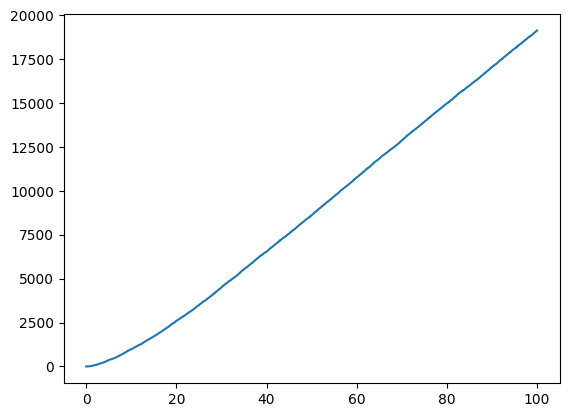

In [65]:
plt.plot(ts1,cell_concs1[0,:,-1])

In [74]:
#compounds,changes,stoichs,rates,v_assoc,rv_assoc

goodCells=[ICell(np.array(list(compounds.values())),changes,stoichs,rates,np.array(list(v_assoc))) for i in range(1)]
#tsPfas,cell_concsPfas=parallel_multicellular(goodCells,np.array([2,3]),1,0,50)

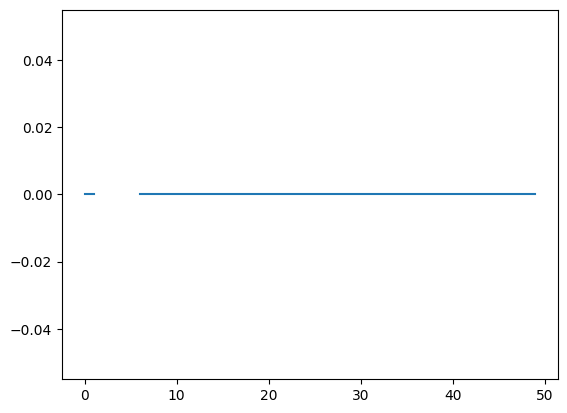

In [14]:
plt.plot(tsPfas,cell_concsPfas[0,:,4])

compounds

In [25]:
cell_concsPfas[0,:,4]

array([0., 0., 0., ..., 0., 0., 0.])

In [7]:
from tqdm import tqdm
import multiprocessing as mp
import time
#@numba.njit()
def cellProcess(cellObj,timeLength,shared_idx,shared_buf_name,record_buffer_name):
    t=0
    shared_mem=mp.shared_memory.SharedMemory(name=shared_buf_name)
    shared=np.array(buffer=shared_mem)
    cellObj.species[shared_idx]=shared
    while t<timeLength: 
        ds,dt=numbaGillespieStep(cellObj.species,cellObj.changes,cellObj.stoichs,cellObj.rates)
        cellObj.species+=ds
    shared[:]=cellObj.species[shared_idx]
    return ds,dt
def trueParallel(cells,shared_idx,timestep,t0,tend):
    nshared=len(shared_idx)
    shared_buf=mp.shared_memory.SharedMemory(create=True, size=nshared*8)
    shared=np.empty(nshared,dtype=np.float64,buffer=shared_buf)
    ts=np.arange(t0,tend,timestep)
    record_buf=mp.shared_memory.SharedMemory(create=True,size=len(ts)*len(cells)*len(cells[0].species)*8)
    record=np.empty((len(ts),len(cells),len(cells[0].species)),dtype=np.float64,buffer=record_buf)
    shared[:]=cells[0].species[shared_idx]
    for cellIdx in range(len(cells)):
        cell=cells[cellIdx]
        process=mp.Process(target=cellProcess,args=(cell,timestep,shared_idx,shared_buf.name,record_buf.name))
@numba.njit(parallel=True)
def numbaGillespieStepP(species,changes,laws,constants):
    propensities=np.ones(changes.shape[0],np.float64)#*constants
    for i in range(changes.shape[0]):
        propensities[i]=np.prod(species**laws[i])
    propensities*=constants
    summed=propensities.sum()
    #print(summed)
    action = weighted_prob(changes,p=propensities/summed)
    #print()
    return action,expovariate(summed)
@numba.njit()
def numbaGillespieRun(species,changes,laws,constants,timestep,t0,tend):
    pass
@numba.njit()
def multicellular3(cells,shared_idx,timestep,t0,tend):
    ts=np.arange(t0,tend,timestep)
    cell0=cells[0]
    shared=cell0.species[shared_idx].copy()
    record=np.ones(shape=(len(cells),len(ts),cell0.species.shape[0]))
    for j in tqdm(range(len(ts))):
        tcount=0
        while tcount<timestep:
            propensities=np.zeros(len(cell0.changes)*len(cells))
            nrxns=len(cell0.changes)
            for i,cell in enumerate(cells):
                cell.species[shared_idx]=shared
                for k in range(nrxns):
                    propensities[k+i*nrxns]=np.prod(cell.species**cell.stoichs[k])*cell.rates[k]
                #propensities[i*nrxns:(i+1)*nrxns]*=cell.rates
            summed=propensities.sum()
            actionIdx=np.searchsorted(np.cumsum(propensities/summed),np.random.random(),side='right')
            cellNum=actionIdx//nrxns
            rxnNum=actionIdx%nrxns
            cells[cellNum].species+=cells[cellNum].changes[rxnNum]
            shared=cells[cellNum].species[shared_idx]
        for idx,cell in enumerate(cells):
            record[idx,j,:]=cell.species
    return record

@numba.njit()
def stacked_multicellular2(cells,shared_idx,timestep,t0,tend):
    #assumed shared_idx is the same across all cells 
    #assuming all cells are the same 
    #shared species will go at the front of the new species array and be taken out of their normal spots for each cell 
    #laws and stoichs will have their shared_idx removed and transferred to the start
    startTime=time.time()
    print('start')
    ts=np.arange(t0,tend,timestep)
    record=np.ones(shape=(len(cells),len(ts),cells[0].species.shape[0]))
    #nonshared=np.arange(len(cells[0].species))[~np.isin(np.arange(len(cells[0].species)),shared_idx)]
    nonshared=np.array([i for i in range(len(cells[0].species)) if i not in shared_idx])
    steps=(tend-t0)//timestep
    nshared=len(shared_idx)
    totalSpecies=nshared+len(cells)*(len(cells[0].species)-nshared)#sum(len(cell.species)-nshared for cell in cells)
    totalRxns=len(cells[0].changes)*len(cells)#sum(len(cell.changes) for cell in cells)
    allSpecies=np.empty(totalSpecies)
    print('allocated species')
    allLaws=np.zeros(shape=(totalRxns,totalSpecies))
    allRates=np.empty(shape=totalRxns)
    allChanges=np.zeros(shape=(totalRxns,totalSpecies))
    sidx=nshared
    ridx=0
    allSpecies[:sidx]=cells[0].species[shared_idx]
    #print(allSpecies.shape,allLaws.shape,allChanges.shape,record.shape)
    #print(nonshared)
    for cell in cells:
        cellSpecies=cell.species
        cellRxns=cell.changes
        #print('ridx',ridx,ridx+cellRxns.shape[0])
        nextSidx=sidx+len(nonshared)
        #print('sidx',sidx,nextSidx)
        #print(len(nonshared),cellSpecies[nonshared])
        allSpecies[sidx:nextSidx]=cellSpecies[nonshared]
        
        allLaws[ridx:ridx+cellRxns.shape[0],sidx:nextSidx]=cell.stoichs[:,nonshared]
        allLaws[ridx:ridx+cellRxns.shape[0],:nshared]=cell.stoichs[:,shared_idx]
        allChanges[ridx:ridx+cellRxns.shape[0],sidx:nextSidx]=cell.changes[:,nonshared]
        allChanges[ridx:ridx+cellRxns.shape[0],:nshared]=cell.changes[:,shared_idx]
        allRates[ridx:ridx+cellRxns.shape[0]]=cell.rates
        #allSharedIdx[cellCount*len(shared_idx):(cellCount+1)*len(shared_idx)]=shared_idx+sidx
        sidx=nextSidx
        ridx+=cellRxns.shape[0]
    print(allSpecies)
    print(allLaws[0])
    print(allChanges)
    #print('r',allRates)
    #return
    tcount=0
    #for i in tqdm(range(len(ts))):
    for i in range(len(ts)):
        while tcount<timestep:
            ds,dt=numbaGillespieStep(allSpecies,allChanges,allLaws,allRates)
            #ds,dt=gillespieStepBetter(allSpecies,allChanges,allLaws,allRates)
            tcount+=dt
            allSpecies+=ds
        tcount=0
        #print(allSpecies)
        for j in range(len(cells)):
            nspecies=len(cells[j].species)
            #print('afasdfsd',allSpecies[nshared+j*len(nonshared):nshared+(j+1)*len(nonshared)])
            record[j,i,nshared:]=allSpecies[nshared+j*len(nonshared):nshared+(j+1)*len(nonshared)]
        record[:,:,:nshared]=allSpecies[:nshared]
    endTime=time.time()
    print('done with sim in', startTime/endTime)

    return ts,record
@numba.njit()
def gillespieStepWithIndex(species, changes, law_coeffs,law_idxs,rates):
    #law_idxs=[np.argwhere(row>0).reshape(-1) for row in laws]
    #law_coeffs=[row[i,law_idxs] for i in range(len(laws))]
    propensities=np.empty(changes.shape[0],np.float64)
    for i in range(len(propensities)):
        propensities[i]=np.prod(species[law_idxs[i]]**law_coeffs[i])
    propensities*=rates
    summed=propensities.sum()
    action=weighted_prob(changes,p=propensities,s=summed)
    dt=expovariate(summed)
    return action,dt
@numba.njit()
def tauWithIndex(species,changes,law_coeffs,law_idxs,rates,dt):
    propensities=np.ones(laws.shape[0],np.float64)
    for i in range(len(propensities)):
        propensities[i]=np.prod(species[law_idxs[i]]**law_coeffs[i])
    #print(propensities)
    propensities*=rates
    ds=np.zeros(species.shape[0],np.float64)
    #print(propensities.shape,ds.shape)
    #actually pretty slow but faster than regular
    for i in range(len(ds)):
        for j in range(len(propensities)):
            p=np.random.poisson(propensities[j]*dt)
            #print(p)
            #print(propensities[j]*dt,propensities[j],dt)
            ds[i]+=changes[j,i]*p
    return ds
@numba.njit(parallel=True)
def stacked_multicellular_idx_based(cells,shared_idx,timestep,t0,tend,maxSteps=float('inf')):
    #assumed shared_idx is the same across all cells 
    #assuming all cells are the same 
    #shared species will go at the front of the new species array and be taken out of their normal spots for each cell 
    #laws and stoichs will have their shared_idx removed and transferred to the start
    ts=np.arange(t0,tend,timestep)
    record=np.ones(shape=(len(cells),len(ts),cells[0].species.shape[0]))
    nonshared=np.array([i for i in range(len(cells[0].species)) if i not in shared_idx])
    steps=(tend-t0)//timestep
    nshared=len(shared_idx)
    totalSpecies=nshared+len(cells)*(len(cells[0].species)-nshared)
    totalRxns=len(cells[0].changes)*len(cells)
    allSpecies=np.empty(totalSpecies)
    allLaws=np.zeros(shape=(totalRxns,totalSpecies))
    allRates=np.empty(shape=totalRxns)
    allChanges=np.zeros(shape=(totalRxns,totalSpecies))
    sidx=nshared
    ridx=0
    allSpecies[:sidx]=cells[0].species[shared_idx]
    for cell in cells:
        cellSpecies=cell.species
        cellRxns=cell.changes
        nextSidx=sidx+len(nonshared)
        allSpecies[sidx:nextSidx]=cellSpecies[nonshared]
        allLaws[ridx:ridx+cellRxns.shape[0],sidx:nextSidx]=cell.stoichs[:,nonshared]
        allLaws[ridx:ridx+cellRxns.shape[0],:nshared]=cell.stoichs[:,shared_idx]
        allChanges[ridx:ridx+cellRxns.shape[0],sidx:nextSidx]=cell.changes[:,nonshared]
        allChanges[ridx:ridx+cellRxns.shape[0],:nshared]=cell.changes[:,shared_idx]
        allRates[ridx:ridx+cellRxns.shape[0]]=cell.rates
        sidx=nextSidx
        ridx+=cellRxns.shape[0]
    allLawIdxs=[np.argwhere(allLaws[i]).flatten() for i in range(len(allLaws))]
    allLawCoeffs=[allLaws[i,allLawIdxs[i]] for i in range(len(allLaws))]
    tcount=0
    steps=0
    for i in range(len(ts)):
        while tcount<timestep:
            ds,dt=gillespieStepWithIndex(allSpecies,allChanges,allLawCoeffs,allLawIdxs,allRates)
            tcount+=dt
            allSpecies+=ds
            steps+=1
            if steps>maxSteps:
                print('max steps exceeded')
                return ts[:i],record[:,:i,:]
        tcount=0
        for j in range(len(cells)):
            nspecies=len(cells[j].species)
            record[j,i,nshared:]=allSpecies[nshared+j*len(nonshared):nshared+(j+1)*len(nonshared)]
        record[:,i,:nshared]=allSpecies[:nshared]
    #print("done with sim in",steps,"steps, about", float(steps/len(ts)),"/",timestep," or ",float(steps/timestep),"/second")
    return ts,record
def clampSpecies(changes,idx):
    a=changes.copy()
    a[idx]=0
    return a



'''
TF+DNA=>TF.DNA
TF.DNA=>TF+DNA
TF.DNA=>mRNA_TF+TF.DNA
mRNA_TF=>null
mRNA_TF=>TF+P
TF=>TF_out
TF_out=>TF
TF=>null
P=>null
~~
A_out=>A
A=>A_out
A+DNA=>A.DNA
A.DNA=>A+DNA
A.DNA=>TF
[tf_out,tf,dna,tf.dna,mrna_tf,null,P]
'''
TFchanges=np.array([
    [0,-1,-1,1,0,0,0],
    [0,1,1,-1,0,0,0],
    [0,0,0,0,1,0,0],
    [0,0,0,0,-1,1,0],
    [0,1,0,0,0,0,1],
    [1,-1,0,0,0,0,0],
    [-1,1,0,0,0,0,0],
    [0,-1,0,0,0,1,0],
    [0,0,0,0,0.,1,-1]
])
nCells=100
tfRates=np.array([.01,1,.1,.05,1,1,.01,.1,.1])
tfLaws=(TFchanges==-1).astype(float)
tfLaws[2,3]=1
tfLaws[4,4]=1
t0=np.array([3000.,0,100,0,0,0,0])
seqCells100=[ICell(t0.copy(),TFchanges.astype(float),tfLaws.astype(float),tfRates.astype(float),np.ones(len(TFchanges)).astype(float)) for i in range(100)]
#seq_ts100,seq_concs100=stacked_multicellular2(seqCells100,np.array([0]),.01,0,20)#about 7 minute runtime
#seq_ts100,seq_concs100=stacked_multicellular_idx_based(seqCells100,np.array([0]),.01,0,20)#about 1 minute run time, 5 sec with numba (20 second simulation)
#seq_ts100,seq_concs100=multicellular3(seqCells100,np.array([0]),.01,0,20)#mega slow

In [11]:
import copy
def printVert(l):
    #for printing lots of numbers so i can copy them into sheets
    for i in l:
        print(i)

#@numba.njit(parallel=False)
def makeReplicate(nCells,species,changes,stoichs,rates, shared_idx,timestep,t0,tend, numReplicate=10):
    #runs simulations many times 
    #returns times and 4d array of records of shape [trial number, cell number, time number, species]
    #take mean per cell record[:,:, -1 , speciesIdx].mean(1)
    ts=np.arange(t0,tend,timestep)
    allRecord=np.empty((numReplicate,nCells,len(ts),len(species)),np.float64)
    populations=[[ICell(species.copy(),changes.copy(),stoichs.copy(),rates.copy(),np.ones(len(stoichs),np.float64)) 
                  for i in range(nCells)] for j in range(numReplicate)]
    for i in tqdm(range(numReplicate)):
    #for i in numba.prange(numReplicate):
    #for i in range(numReplicate):
        cells=populations[i]
        _,trialRecord=stacked_multicellular_idx_based(cells,np.array([0]),timestep,t0,tend)
        allRecord[i,:,:,:]=trialRecord
    print('done')
    return ts,allRecord
ts1,cell_concs1=makeReplicate(1,t0,TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,20,50)
#32 seconds for 1 cell 100 trials sequential, crashes with numba parallel also about 30 sec with numba


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.27it/s]

done


In [30]:
makeReplicate(10,t0,TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,20,50)
0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:57<00:00,  2.34s/it]

done


0

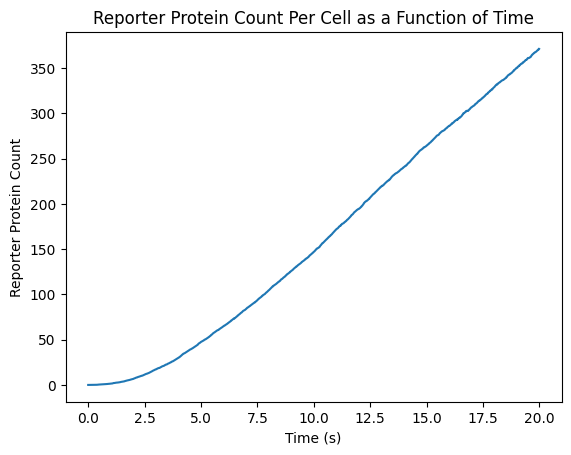

mean overall P concentration
371.24
aggregate overall P concentration
371.24
mean concentrations per trial
452.0
472.0
454.0
265.0
348.0
340.0
396.0
451.0
254.0
303.0
338.0
372.0
407.0
435.0
389.0
437.0
340.0
340.0
364.0
482.0
369.0
337.0
364.0
403.0
330.0
334.0
335.0
443.0
318.0
342.0
282.0
478.0
370.0
297.0
360.0
356.0
321.0
348.0
393.0
293.0
438.0
405.0
418.0
322.0
360.0
347.0
430.0
407.0
364.0
359.0
mean aggregate P production
452.0
472.0
454.0
265.0
348.0
340.0
396.0
451.0
254.0
303.0
338.0
372.0
407.0
435.0
389.0
437.0
340.0
340.0
364.0
482.0
369.0
337.0
364.0
403.0
330.0
334.0
335.0
443.0
318.0
342.0
282.0
478.0
370.0
297.0
360.0
356.0
321.0
348.0
393.0
293.0
438.0
405.0
418.0
322.0
360.0
347.0
430.0
407.0
364.0
359.0


In [33]:
plt.plot(ts1,cell_concs1[:,:,:,-1].mean(0).T)
plt.xlabel("Time (s)")
plt.title("Reporter Protein Count Per Cell as a Function of Time")
plt.ylabel("Reporter Protein Count")
plt.show()
print('mean overall P concentration')
print(cell_concs1[:,:,-1,-1].mean())
print('aggregate overall P concentration')
print(cell_concs1[:,:,-1,-1].mean(0).sum())
print('mean concentrations per trial')
printVert(cell_concs1[:,:,-1,-1].mean(1))
print('mean aggregate P production')
printVert(cell_concs1[:,:,-1,-1].sum(1))


In [14]:
ts10,cell_concs10=makeReplicate(10,t0,TFchanges,tfLaws,tfRates,np.array([0]),.01,0,20,50)#about 3 minutes for 100 trials

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:56<00:00,  2.33s/it]

done


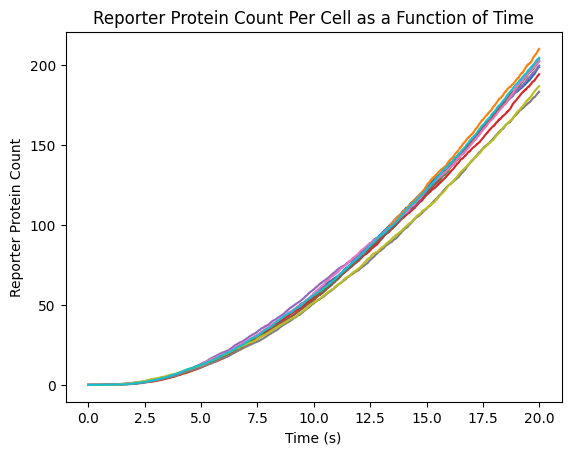

mean overall P concentration
198.634
aggregate overall P concentration
1986.34
mean concentrations per trial
199.4
189.7
214.7
219.3
192.4
185.7
207.5
203.9
194.0
194.7
184.5
199.9
207.7
198.5
200.9
179.9
225.7
171.5
206.2
194.6
194.0
197.4
209.2
192.6
175.9
191.6
213.1
191.3
203.7
191.2
188.6
198.5
212.8
215.2
193.3
190.9
167.6
180.9
190.5
204.8
201.6
201.4
195.9
221.6
217.7
201.7
195.9
200.5
212.7
208.9
mean aggregate P production
1994.0
1897.0
2147.0
2193.0
1924.0
1857.0
2075.0
2039.0
1940.0
1947.0
1845.0
1999.0
2077.0
1985.0
2009.0
1799.0
2257.0
1715.0
2062.0
1946.0
1940.0
1974.0
2092.0
1926.0
1759.0
1916.0
2131.0
1913.0
2037.0
1912.0
1886.0
1985.0
2128.0
2152.0
1933.0
1909.0
1676.0
1809.0
1905.0
2048.0
2016.0
2014.0
1959.0
2216.0
2177.0
2017.0
1959.0
2005.0
2127.0
2089.0


In [34]:
plt.plot(ts10,cell_concs10[:,:,:,-1].mean(0).T)
plt.xlabel("Time (s)")
plt.title("Reporter Protein Count Per Cell as a Function of Time")
plt.ylabel("Reporter Protein Count")
plt.show()
print('mean overall P concentration')
print(cell_concs10[:,:,-1,-1].mean())
print('aggregate overall P concentration')
print(cell_concs10[:,:,-1,-1].mean(0).sum())
print('mean concentrations per trial')
printVert(cell_concs10[:,:,-1,-1].mean(1))
print('mean aggregate P production')
printVert(cell_concs10[:,:,-1,-1].sum(1))

In [19]:
ts100,cell_concs100=makeReplicate(100,t0,TFchanges,tfLaws,tfRates,np.array([0]),.01,0,20,50) 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [40:17<00:00, 48.36s/it]

done


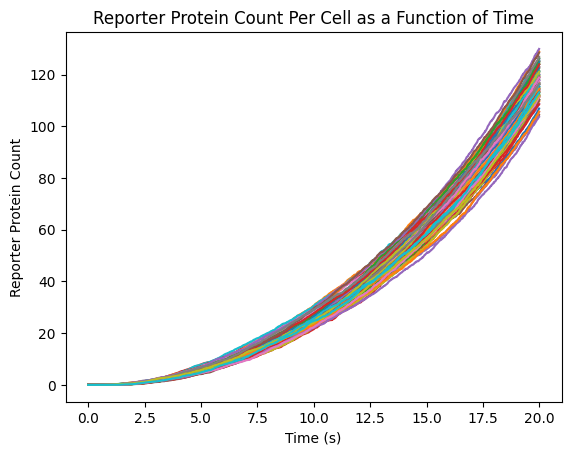

mean overall P concentration
117.232
aggregate overall P concentration
11723.200000000003
mean concentrations per trial
115.24
122.75
116.9
120.72
125.12
115.7
111.12
110.93
115.98
114.01
123.64
121.65
115.57
118.99
114.0
112.49
114.5
122.85
114.07
117.21
117.36
116.38
120.75
118.11
124.51
117.28
121.31
111.02
121.48
114.12
110.38
116.52
121.62
113.48
116.47
117.85
109.47
110.19
119.49
112.85
118.93
112.79
121.44
114.52
126.03
124.18
117.82
122.6
112.85
116.36
mean aggregate P production
11524.0
12275.0
11690.0
12072.0
12512.0
11570.0
11112.0
11093.0
11598.0
11401.0
12364.0
12165.0
11557.0
11899.0
11400.0
11249.0
11450.0
12285.0
11407.0
11721.0
11736.0
11638.0
12075.0
11811.0
12451.0
11728.0
12131.0
11102.0
12148.0
11412.0
11038.0
11652.0
12162.0
11348.0
11647.0
11785.0
10947.0
11019.0
11949.0
11285.0
11893.0
11279.0
12144.0
11452.0
12603.0
12418.0
11782.0
12260.0
11285.0
11636.0


In [35]:
plt.plot(ts100,cell_concs100[:,:,:,-1].mean(0).T)
plt.xlabel("Time (s)")
plt.title("Reporter Protein Count Per Cell as a Function of Time")
plt.ylabel("Reporter Protein Count")
plt.show()
print('mean overall P concentration')
print(cell_concs100[:,:,-1,-1].mean())
print('aggregate overall P concentration')
print(cell_concs100[:,:,-1,-1].mean(0).sum())
print('mean concentrations per trial')
printVert(cell_concs100[:,:,-1,-1].mean(1))
print('mean aggregate P production')
printVert(cell_concs100[:,:,-1,-1].sum(1))

0

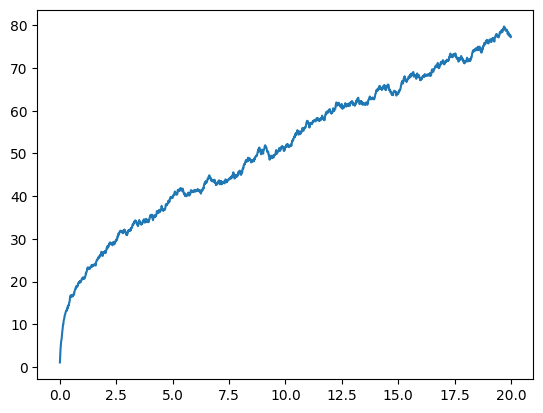

In [49]:
plt.plot(ts10,cell_concs1[:,:,:,1].mean(0).T.mean(1))
0

In [28]:
ts50,cell_concs50=makeReplicate(50,t0,TFchang3es,tfLaws,tfRates,np.array([0]),.01,0,20,50) 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [27:59<00:00, 33.59s/it]

done


In [32]:
ts500,cell_concs500=makeReplicate(500,t0,TFchanges,tfLaws,tfRates,np.array([0]),.01,0,20,50) 

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 32/50 [4:26:33<2:29:56, 499.79s/it]


SystemError: CPUDispatcher(<function stacked_multicellular_idx_based at 0x13822d940>) returned a result with an error set

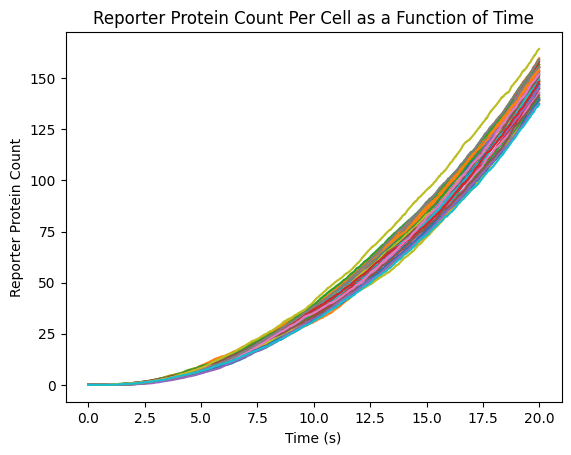

mean overall P concentration
148.5812
aggregate overall P concentration
7429.0599999999995
mean concentrations per trial
148.6
138.7
142.38
152.82
143.42
146.82
163.34
137.26
156.66
145.58
148.5
145.2
146.56
154.16
150.7
158.64
157.08
149.58
141.88
144.98
148.34
145.16
143.3
150.56
141.56
165.72
146.92
136.62
139.7
136.98
155.74
151.52
161.98
145.06
150.9
145.68
162.22
151.48
155.12
139.78
157.98
146.9
141.9
144.68
150.94
158.46
147.38
139.64
148.68
145.3
mean aggregate P production
7430.0
6935.0
7119.0
7641.0
7171.0
7341.0
8167.0
6863.0
7833.0
7279.0
7425.0
7260.0
7328.0
7708.0
7535.0
7932.0
7854.0
7479.0
7094.0
7249.0
7417.0
7258.0
7165.0
7528.0
7078.0
8286.0
7346.0
6831.0
6985.0
6849.0
7787.0
7576.0
8099.0
7253.0
7545.0
7284.0
8111.0
7574.0
7756.0
6989.0
7899.0
7345.0
7095.0
7234.0
7547.0
7923.0
7369.0
6982.0
7434.0
7265.0


In [36]:
plt.plot(ts50,cell_concs50[:,:,:,-1].mean(0).T)
plt.xlabel("Time (s)")
plt.title("Reporter Protein Count Per Cell as a Function of Time")
plt.ylabel("Reporter Protein Count")
plt.show()
print('mean overall P concentration')
print(cell_concs50[:,:,-1,-1].mean())
print('aggregate overall P concentration')
print(cell_concs50[:,:,-1,-1].mean(0).sum())
print('mean concentrations per trial')
printVert(cell_concs50[:,:,-1,-1].mean(1))
print('mean aggregate P production')
printVert(cell_concs50[:,:,-1,-1].sum(1))

In [22]:
t1=t0.copy()
#t0_mod=np.array([100.,0,1000,0,0,0,0])
seqCells10=[ICell(t0.copy(),TFchanges.astype(float),tfLaws.astype(float),tfRates.astype(float),np.ones(len(TFchanges)).astype(float)) for i in range(10)]
seq_ts10,seq_concs10=stacked_multicellular_idx_based(seqCells10,np.array([0]),
                       .01,0,20)

start
start mainloop
done with sim in 31702 steps, about 15.851 / 0.01  or  3170200.0 /second


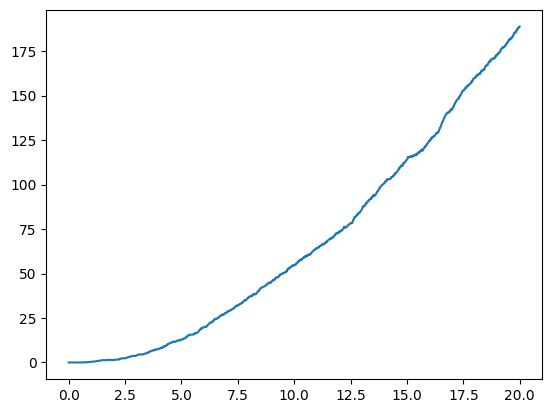

In [24]:
plt.plot(seq_ts10,seq_concs10[:,:,-1].T.mean(1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:24<00:00,  6.49s/it]

done


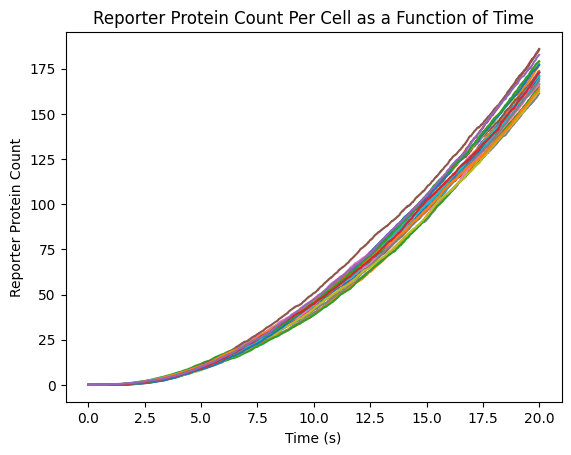

mean overall P concentration
172.5456
aggregate overall P concentration
4313.639999999999
mean concentrations per trial
180.4
187.56
165.4
176.08
162.08
168.4
168.08
171.16
173.48
163.8
164.64
154.76
169.52
167.4
176.52
171.68
168.96
175.96
173.64
168.72
185.48
179.56
169.88
184.4
178.72
165.2
159.48
177.96
167.68
184.8
171.32
178.96
180.08
158.0
163.52
160.48
183.6
167.52
167.12
165.24
177.2
189.64
179.08
192.88
167.68
175.48
169.84
164.6
163.92
189.72
mean aggregate P production
4510.0
4689.0
4135.0
4402.0
4052.0
4210.0
4202.0
4279.0
4337.0
4095.0
4116.0
3869.0
4238.0
4185.0
4413.0
4292.0
4224.0
4399.0
4341.0
4218.0
4637.0
4489.0
4247.0
4610.0
4468.0
4130.0
3987.0
4449.0
4192.0
4620.0
4283.0
4474.0
4502.0
3950.0
4088.0
4012.0
4590.0
4188.0
4178.0
4131.0
4430.0
4741.0
4477.0
4822.0
4192.0
4387.0
4246.0
4115.0
4098.0
4743.0


In [50]:
def runAnalysis(ts,concs):
    plt.plot(ts,concs[:,:,:,-1].mean(0).T)
    plt.xlabel("Time (s)")
    plt.title("Reporter Protein Count Per Cell as a Function of Time")
    plt.ylabel("Reporter Protein Count")
    plt.show()
    print('mean overall P concentration')
    print(concs[:,:,-1,-1].mean())
    print('aggregate overall P concentration')
    print(concs[:,:,-1,-1].mean(0).sum())
    print('mean concentrations per trial')
    printVert(concs[:,:,-1,-1].mean(1))
    print('mean aggregate P production')
    printVert(concs[:,:,-1,-1].sum(1))
runAnalysis(*makeReplicate(25,t0,TFchanges,tfLaws,tfRates,np.array([0]),.01,0,20,50) )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [17:54<00:00, 21.50s/it]


done


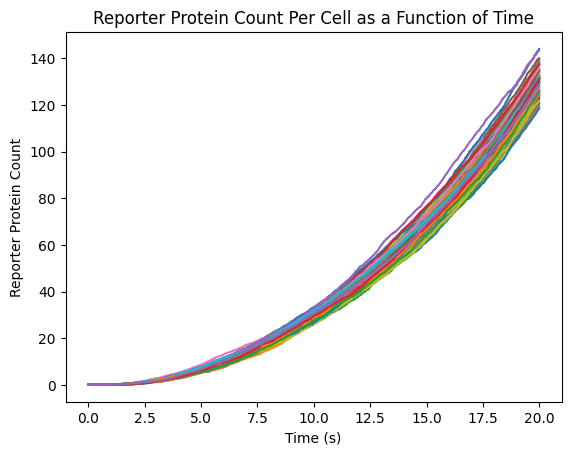

mean overall P concentration
130.34186666666668
aggregate overall P concentration
9775.64
mean concentrations per trial
135.0
139.50666666666666
139.70666666666668
126.82666666666667
118.48
142.12
129.09333333333333
130.21333333333334
132.72
129.48
124.6
133.26666666666668
130.28
136.73333333333332
128.58666666666667
127.73333333333333
127.54666666666667
134.38666666666666
123.65333333333334
138.72
127.29333333333334
132.37333333333333
126.61333333333333
127.13333333333334
143.21333333333334
123.05333333333333
142.52
130.56
138.16
132.06666666666666
124.38666666666667
128.22666666666666
122.18666666666667
123.52
121.81333333333333
126.06666666666666
131.81333333333333
124.01333333333334
138.32
128.12
129.4
123.26666666666667
133.86666666666667
139.08
136.8
130.86666666666667
126.21333333333334
128.81333333333333
126.93333333333334
121.74666666666667
mean aggregate P production
10125.0
10463.0
10478.0
9512.0
8886.0
10659.0
9682.0
9766.0
9954.0
9711.0
9345.0
9995.0
9771.0
10255.0
9644.0


In [51]:
runAnalysis(*makeReplicate(75,t0,TFchanges,tfLaws,tfRates,np.array([0]),.01,0,20,50))

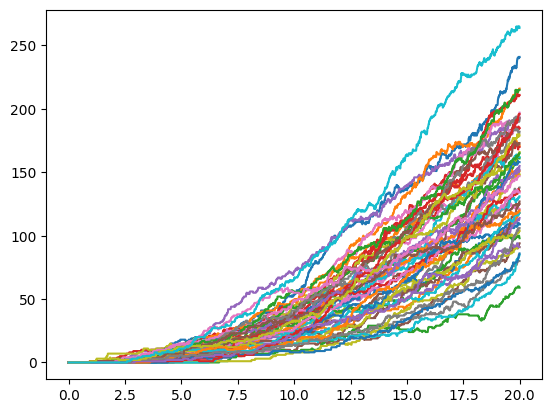

In [67]:
plt.plot(ts1,cell_concs50[:1,:,:,-1].mean(0).T)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (2000,) and (100, 2000)

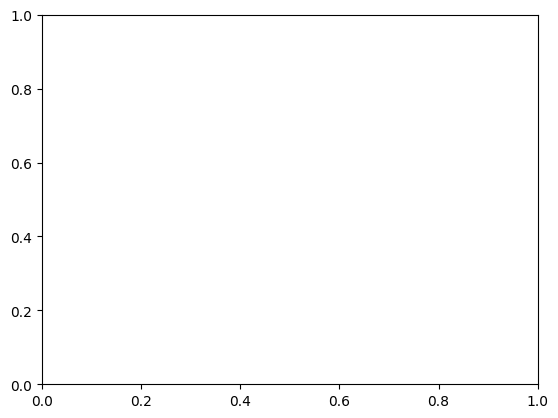

In [64]:
plt.plot(ts100,cell_concs100[1,:,:,-1])
plt.show()

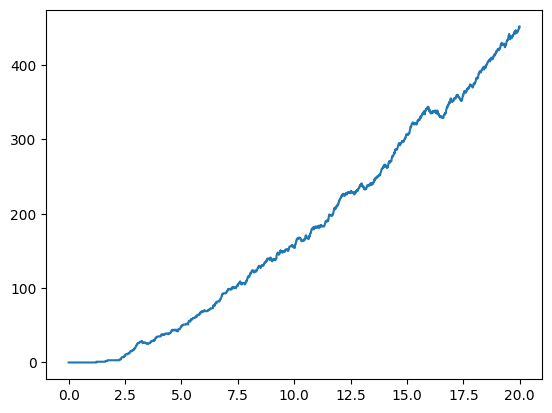

In [61]:
plt.plot(ts1,cell_concs1[:1,:,:,-1].mean(0).T)
plt.show()

<BarContainer object of 10 artists>

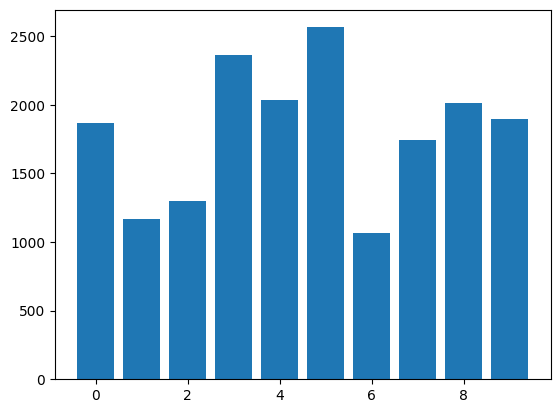

In [45]:
plt.bar(range(10),seq_concs10[:,-1,-1])

In [5]:
#[tf_out,tf,dna,tf.dna,mrna_tf,null,P]

'sf'

In [26]:

seqCells1=[ICell(t0.copy(),TFchanges.astype(float),tfLaws.astype(float),tfRates.astype(float),np.ones(len(TFchanges)).astype(float)) for i in range(1)]
seq_ts1,seq_concs1=stacked_multicellular_idx_based(seqCells1,np.array([0]),
                       .01,0,20)

start
start mainloop
done with sim in 5448 steps, about 2.724 / 0.01  or  544800.0 /second


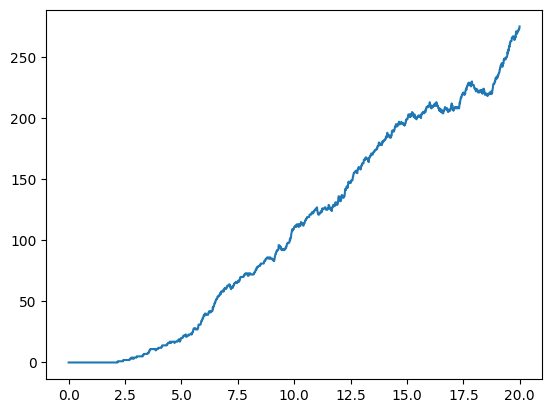

In [29]:
plt.plot(seq_ts1,seq_concs1[0,:,-1])

In [29]:
tfRatesBigger=np.array([.01,1,.1,.005,1,.1,.1,.001,.001])
tBig=np.array([100.,0,10000,0,0,0,0])
seqCellBig=[ICell(tBig.copy(),TFchanges.astype(float),tfLaws.astype(float),tfRates.astype(float),np.ones(len(TFchanges)).astype(float)) for i in range(1)]
seq_tsBig,seq_concsBig=stacked_multicellular2(seqCellBig,np.array([0]),
                       .01,0,20)

start
allocated species
[  100.     0. 10000.     0.     0.     0.     0.]
[0. 1. 1. 0. 0. 0. 0.]
[[ 0. -1. -1.  1.  0.  0.  0.]
 [ 0.  1.  1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.]
 [ 0.  1.  0.  0.  0.  0.  1.]
 [ 1. -1.  0.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1. -1.]]
done with sim


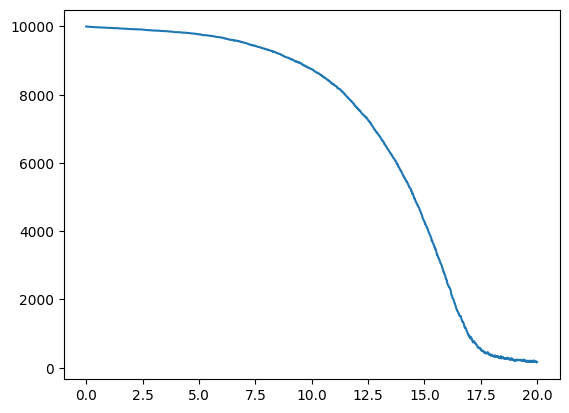

In [31]:
plt.plot(seq_tsBig,seq_concsBig[0,:,-5])

In [ ]:
seqCells1000=[ICell(t0.copy(),TFchanges.astype(float),tfLaws.astype(float),tfRates.astype(float),np.ones(len(TFchanges)).astype(float)) for i in range(1000)]
seq_ts1000,seq_concs1000=stacked_multicellular2(seqCells1000,np.array([0]),
                       .01,0,20)

In [ ]:
compounds,changes,stoichs,rates,v_assoc,rv_assoc
pfasCells=[ICell(np.array(list(compounds.values())),changes,stoichs,rates,np.array(list(v_assoc))) for i in range(10)]
print(pfasCells[0].species)
pfasTs,pfasConcs=stacked_multicellular2(pfasCells,np.array([2,3]),
                       .01,0,10)

In [39]:
plt.plot(pfasTs,pfasConcs[0,:,3])

NameError: name 'pfasTs' is not defined

In [33]:
singlePfasCell=[ICell(np.array(list(compounds.values())),changes,stoichs,rates,np.array(list(v_assoc))) for i in range(5)]
pfasTsSingle,pfasConcsSingle=stacked_multicellular_idx_based(singlePfasCell,np.array([2,3]),
                       .01,0,10)

start
start mainloop
done with sim in 6913388 steps, about 6913.388 / 0.01  or  691338800.0 /second


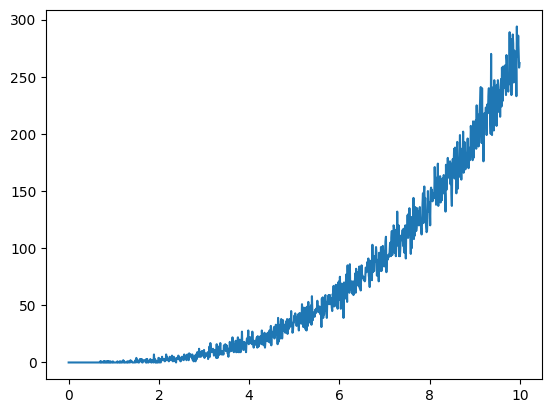

In [38]:
plt.plot(pfasTsSingle,pfasConcsSingle[0,:,4])

In [32]:
compound_names=(['LuxRinCell', 'luxR_gene', 'PFAS_outside', '_3OC6HSL_out', '_3OC6HSL_inside', 'GFP_Inside', 'pLux_operon', 'PFAS_Inside', 'prmA_Operon', 'LuxI', '_3OC6HSL_pre', 'DegradedGFP', 'DegradedLuxI', 'DegradedLuxR', 'LuxR_pLux_Cplx', 'PFOA_prmA_Cplx', 'LuxI_mRNA', 'GFP_mRNA', 'LuxR_mRNA', 'DegmRNA', 'Degr_LuxImRNA', 'Deg_GFPmRNA', 'LuxR_3OC6HSL', 'DegradedLuxR_3oc'])
for i,c in enumerate(compound_names):
    print(c,i)

LuxRinCell 0
luxR_gene 1
PFAS_outside 2
_3OC6HSL_out 3
_3OC6HSL_inside 4
GFP_Inside 5
pLux_operon 6
PFAS_Inside 7
prmA_Operon 8
LuxI 9
_3OC6HSL_pre 10
DegradedGFP 11
DegradedLuxI 12
DegradedLuxR 13
LuxR_pLux_Cplx 14
PFOA_prmA_Cplx 15
LuxI_mRNA 16
GFP_mRNA 17
LuxR_mRNA 18
DegmRNA 19
Degr_LuxImRNA 20
Deg_GFPmRNA 21
LuxR_3OC6HSL 22
DegradedLuxR_3oc 23


In [87]:
@numba.njit()
def testArg(laws):
    a= [np.argwhere(laws[i]>0) for i in range(len(laws))]
    return a
tfLaws[0,testArg(tfLaws)[0]]

array([[1.],
       [1.]])

In [37]:
cell_concs1.tofile('save_1cell')

In [38]:
cell_concs10.tofile('save_10cell')

In [39]:
cell_concs50.tofile('save_50cell')

In [40]:
cell_concs100.tofile('save_100cell')

In [43]:
(np.fromfile('save_10cell').reshape(cell_concs10.shape)==cell_concs10).all()

True

In [44]:
moreTFts,moreTFConcs=makeReplicate(1,np.array([30000.,0,100,0,0,0,0]),TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,20,50)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.22it/s]

done


In [47]:
moreTFConcs.shape

(50, 1, 2000, 7)

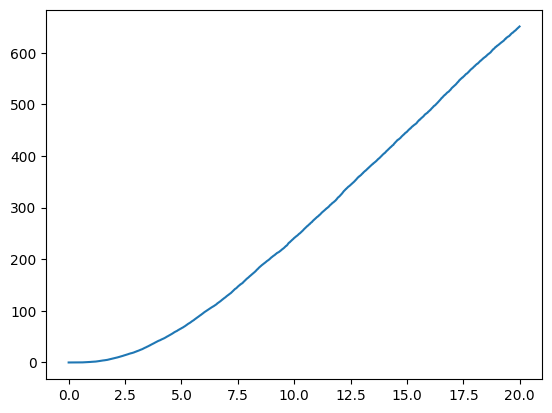

In [48]:
plt.plot(moreTFts,moreTFConcs[:,0,:,-1].mean(0))